# Image segmentation with Convolutional Neural Networks

Image segmentation is a classic task in computer vision. The goal is to group the pixels in an image according to a given criterion. Segmentation finds application in many domains, from medical imaging to industrial inspection, autonomous driving, and more.

Classic methods for image segmentation group pixels into regions of uniform color or texture. Many of these methods use clustering algorithms.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/a/aa/Polarlicht_2.jpg/320px-Polarlicht_2.jpg) → ![](https://upload.wikimedia.org/wikipedia/commons/thumb/c/c5/Polarlicht_2_kmeans_16_large.png/320px-Polarlicht_2_kmeans_16_large.png)

More recently, **semantic** segmentation became a very popular topic.
In semantic segmentation, the regions reflect the content of the image. Ideally, each segment represents one kind of object in the scene.

![](https://cs.stanford.edu/~roozbeh/pascal-context/2008_002123.jpg)

$\downarrow$

![](https://cs.stanford.edu/~roozbeh/pascal-context/2008_002123L.png)

Semantic segmentation entails a pixel-level classification, where each pixel is labeled with one class taken from a set of predefined classes.

Convolutional Neural Networks (CNN) are good candidates for solving this problem. A CNN may analyze the whole image and then output a vector of probability estimates for each pixel. Segmentation is achieved by labeling pixels as the class corresponding to the highest estimate.

## Pet segmentation

In this exercise, we will address a relatively simple semantic segmentation problem. More precisely, we want to build a model capable of segmenting images of pets.

We will use the [Oxford Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/), which includes 7349 images of cats and dogs, each with a manually defined segmentation mask.

![](https://www.robots.ox.ac.uk/~vgg/data/pets/pet_annotations.jpg)


Here, we have three classes:
- class 0 is the background of the picture;
- class 1 is a pixel of a cat;
- class 2 is a pixel of a dog.

The dataset also includes bounding boxes, which are useful for training models for object detection but which we won't use.

## Setup and Data

he dataset is distributed as pairs of files representing an image of a pet and the corresponding segmentation map. Files are organized in a tree of directories with the following structure:
* the root (`pets`) includes four directories: `train_images`, `train_maps`, `test_images`, `test_maps`;
* each folder includes 37 folders representing different breeds of cats and dogs (the breed is not relevant information for this project);
* each breed folder contains a set of image files: .jpg for the images, .png for the segmentation maps.

Folders containing images and maps have the same structure, so it is possible to pair their content. For instance, the files
* `pets/test_images/Abyssinian/Abyssinian_105.jpg`
* and `pets/test_maps/Abyssinian/Abyssinian_105.png`
form an image/map pair.

This structure allows the simple definition of a torch `Dataset` class, yielding pairs of corresponding images and maps.

Images are encoded as RGB JPEG-compressed files and can be processed by standard tools in the `torchvision` module.

Maps are grayscale PNG-compressed files. Each pixel in the segmentation map may assume the values 0, 100, and 200 representing the classes background, cat and dog. We will need to convert RGB (which is the torchvision default) maps to grayscale and map the values in the 0, 1, 2 integers we will use as class labels.

In [1]:
import os


In [2]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import google.colab
import zipfile
import pickle
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
google.colab.drive.mount('/content/drive')
zip_file_path =  "/content/drive/MyDrive/Colab Notebooks/pet-segmentation.zip"
# Extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall("/content/pet-segmentation")

print("Extraction complete.")


Mounted at /content/drive
Extraction complete.


To manage the data, we will define our own `Dataset`, which will include two sub-datasets: one for the RGB images and the other for the segmentation maps. Our dataset must correctly pair the two kinds of images.

In [4]:
import torch
import torchvision
import os
import matplotlib.pyplot as plt

class PetsDataset(torch.utils.data.Dataset):
    def __init__(self, root, train, img_transform, map_transform):
        # create 2 datasets: one for the photographs the other for the segmentation maps
        prefix = "train_" if train else "test_"
        images_dir = os.path.join(root, prefix + "images")
        self.images = torchvision.datasets.ImageFolder(images_dir, transform=img_transform)
        maps_dir = os.path.join(root, prefix + "maps")
        self.maps = torchvision.datasets.ImageFolder(maps_dir, transform=map_transform)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        # given an index inside the dataset, return the specific item it refers to
        image = self.images[index][0]  # self.image[index] contain image foto and label foto,
        map = self.maps[index][0]  # self.maps[index] map foto and map label
        return image, map

MEAN_RGB = [0.4849, 0.4495, 0.3966]
STDDEV_RGB = [0.2631, 0.2584, 0.2652]

def process_map(mapdata):
    # RGB to Grayscale and conversion to the integer labels 0, 1, 2.
    return (mapdata[0:1, :, :] * 255 / 100).long()

img_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(MEAN_RGB, STDDEV_RGB)
])

map_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    process_map
])

root_path = "/content/pet-segmentation/pets"

train_set = PetsDataset(root_path, True, img_transform, map_transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True, drop_last=True, num_workers=2)
test_set = PetsDataset(root_path, False, img_transform, map_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=16, shuffle=True, drop_last=True, num_workers=2)

def show_batch(images, maps):
    g = torchvision.utils.make_grid(images, normalize=True)
    plt.rcParams['figure.dpi'] = 200
    plt.imshow(g.permute(1, 2, 0))
    plt.axis("off")
    plt.figure()

    g = torchvision.utils.make_grid(maps)
    plt.imshow(g[0], interpolation="nearest", cmap="brg", vmin=0, vmax=2)
    plt.axis("off")
    plt.show()


torch.Size([16, 3, 160, 160]) torch.float32 torch.Size([16, 1, 160, 160]) torch.int64


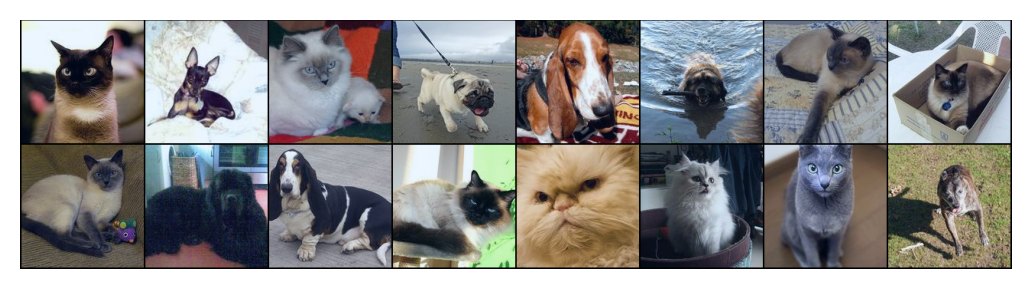

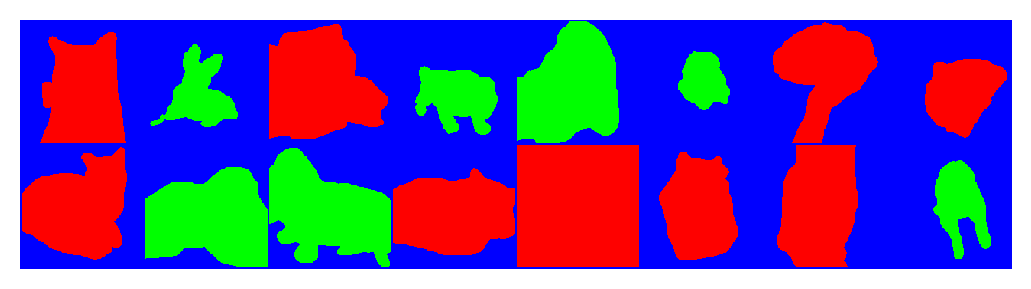

In [5]:
image, map = next(iter(train_loader))
print(image.shape, image.dtype, map.shape, map.dtype)
show_batch(image, map)

## Convolutional Networks for semantic segmentation

A typical CNN for image classification includes two main components. First, convolutional layers extract local features from the input image. The number of features increases layer after layer. At the same time, pooling layers reduce the spatial resolution. At some point, global pooling (or flattening) reduces the local features to a single vector.
The second component is a multi-layer perceptron (MLP) made of fully connected layers, ending with a vector of probability estimates. We can visualize the shape of such a network as a pyramid.

Convolutional Neural Networks can be used for segmentation as well. The MLP component is removed to preserve spatial information. Instead, a decoder is introduced to restore the original resolution and perform a pixel-level classification. The first example of this approach is the Fully Convolutional Network (FCN), described in the paper:

J. Long, E. Shelhamer and T. Darrel, "Fully Convolutional Networks for Semantic Segmentation," CVPR 2015 [(PDF)](https://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Long_Fully_Convolutional_Networks_2015_CVPR_paper.pdf).

Here, we will define a symmetric encoder/decoder network. The *Encoder* is like the convolutional part of a CNN for image classification. The *Decoder* acts specularly by progressively restoring the original spatial resolution and reducing the number of features. This network would have the shape of an hourglass.

Each step is obtained by a *convolutional block* including two convolutions, normalization layers, and ReLUs. It also optionally applies max pooling (to reduce spatial resolution) and upscale layers (to increase it). The convolutional block is implemented as a pytorch `Module`:

In [6]:
# Must be flexible enough to be used in the Encoder, in the Bottleneck and in the Decoder
class ConvBlock(torch.nn.Module):
    def __init__(self, inchannels, outchannels, downscale, upscale): # Last 2 parameters are boolean
      super(ConvBlock, self).__init__()
      self.conv1 = torch.nn.Conv2d(inchannels, outchannels, 3, padding = 1) # 2D convolution
                                                                            # padding = 1 preserve the size of the image with conv 3x3
      self.bnorm1 = torch.nn.BatchNorm2d(outchannels)
      self.conv2 = torch.nn.Conv2d(outchannels, outchannels, 3, padding = 1)
      self.bnorm2 = torch.nn.BatchNorm2d(outchannels)
      self.up = torch.nn.Upsample(scale_factor=2) if upscale else torch.nn.Identity()
      self.down = torch.nn.MaxPool2d(2) if downscale else torch.nn.Identity() # 2x2 max_poooling, moves along image with stride = 2 = pooling_size, thus 40/2 = 20 = output, where 40 is input

    def forward(self, x):
      x = self.up(x)
      x = torch.nn.functional.relu(self.bnorm1(self.conv1(x)))
      x = torch.nn.functional.relu(self.bnorm2(self.conv2(x)))
      x=self.down(x)
      return x
x = torch.zeros(1,10,40,40) #10 channels, 40x40
block=ConvBlock(10,15,True, False)
y=block(x)
print(x.shape, '-->',y.shape)

torch.Size([1, 10, 40, 40]) --> torch.Size([1, 15, 20, 20])


Blocks are assembled to define the FCN. We will follow the scheme:

$\text{input} \xrightarrow{Encoder} \cdot \xrightarrow{Bottleneck} \cdot \xrightarrow{Decoder} \text{output}$

where:
* The Encoder is a sequence of convolutional blocks with max pooling;
* The Decoder is a sequence of convolutional blocks with upsampling;
* The Bottleneck is a single convolution block (with both pooling and upsampling).

In [7]:
c = [3] + [64* (2**i) for i in range(3)]
print(c)
c[0] = 64
print(c)
for i in range(3-1, -1, -1):
  print(i+1, i)

[3, 64, 128, 256]
[64, 64, 128, 256]
3 2
2 1
1 0


In [8]:
class EncoderDecoder(torch.nn.Module):
    def __init__(self, classes, depth, width):
        super(EncoderDecoder, self).__init__()
        self.encoder = torch.nn.ModuleList()

      # Module class in pytorch automatically register a module once you create it and does the same with parameters =>
      # => EncoderDecoder class see Module parameters as its own parameters
      # This is not possible using a python list.

        # channels = [3, width, 2*width, 4*width .....]
        channels = [3] + [width* (2**i) for i in range(depth)]
        for i in range(depth):
          self.encoder.append(ConvBlock(channels[i], channels[i+1], True, False))

        self.bottleneck = ConvBlock(channels[-1], channels[-1], True, True)

        self.decoder = torch.nn.ModuleList()
        channels[0] = width
        for i in range(depth-1, -1, -1): #to count backward
          self.decoder.append(ConvBlock(channels[i+1], channels[i], False, True))

        self.classifier = torch.nn.Conv2d(channels[0], classes, 1) #0 since 1x1 conv
#use softmax in loss function otherwise we loose information,
#softmax squeeze values and then in loss it unsqueeze but i have already lost information due to numerical computation, i want to know which score originated which value of softmax ??
    def forward(self, x):
      for block in self.encoder:
        x=block(x)
      x = self.bottleneck(x)
      for block in self.decoder:
        x=block(x)
      x = self.classifier(x)
      return x

x = torch.zeros(1,3,160,160)
net = EncoderDecoder(3,3,64)
# print(net)
y = net(x)
print(x.shape, '-->', y.shape )
# for p in net.parameters():
  # print(p.shape)


torch.Size([1, 3, 160, 160]) --> torch.Size([1, 3, 160, 160])


## Training loop

Since semantic segmentation can be seen as pixel-level classification, we can use cross entropy as loss function. We just need to average it over all pixels in the batch of images. Beside that, the training loop has no special features.

In [9]:
EPOCHS = 10
LR = 0.001
print(DEVICE)
net.to(DEVICE)
net.train()
optimizer = torch.optim.Adam(net.parameters(),LR)
loss_fun = torch.nn.CrossEntropyLoss().to(DEVICE)

steps = 0
for epoch in range(EPOCHS):
  for images, labels in train_loader:
    images=images.to(DEVICE)
    labels=labels.to(DEVICE)
    optimizer.zero_grad()
    steps += 1
    map = net(images)
    loss = loss_fun(map, labels.squeeze(1)) # labels from torch.Size([16, 1, 160, 160]) ---> torch.Size([16, 160, 160]) == torch.Size([batch, rows_pixel, columns_pixel])
                                            # thus for each channel of the same image coming from net(images) there is the same label image coming from labels.squeeze(1)
    loss.backward()
    optimizer.step()
    if steps % 50 == 0:
      predictions = map.argmax(1)
      accuracy = (predictions == labels.squeeze(1)).float().mean()
      print(f"{steps}[{epoch}] loss: {loss.item():.4f} accuracy: {accuracy*100:.1f}")
data = {
    "net": net.state_dict(),
    "optimizer": optimizer.state_dict()
}
torch.save(data, zip_file_path+"segmentation.pt")

cuda
50[0] loss: 0.9605 accuracy: 56.2
100[0] loss: 0.8312 accuracy: 62.5
150[0] loss: 0.8026 accuracy: 66.2
200[0] loss: 0.7028 accuracy: 72.1
250[0] loss: 0.9584 accuracy: 50.8
300[0] loss: 0.6577 accuracy: 74.1
350[0] loss: 0.6702 accuracy: 73.8
400[1] loss: 0.8354 accuracy: 68.7
450[1] loss: 0.8897 accuracy: 60.6
500[1] loss: 0.6643 accuracy: 75.7
550[1] loss: 0.8113 accuracy: 64.6
600[1] loss: 0.6090 accuracy: 78.3
650[1] loss: 0.6099 accuracy: 75.9
700[1] loss: 0.5785 accuracy: 77.4
750[1] loss: 0.6904 accuracy: 67.9
800[2] loss: 0.5137 accuracy: 82.2
850[2] loss: 0.7596 accuracy: 59.3
900[2] loss: 0.6946 accuracy: 68.3
950[2] loss: 0.5328 accuracy: 80.0
1000[2] loss: 0.6410 accuracy: 71.2
1050[2] loss: 0.7684 accuracy: 62.1
1100[2] loss: 0.5327 accuracy: 76.1
1150[2] loss: 0.5664 accuracy: 74.4
1200[3] loss: 0.5089 accuracy: 79.1
1250[3] loss: 0.6259 accuracy: 72.5
1300[3] loss: 0.5677 accuracy: 77.3
1350[3] loss: 0.4783 accuracy: 80.9
1400[3] loss: 0.5486 accuracy: 77.3
1450[3]

## Evaluation

We can use different statistics to measure performance. Accuracy is the most straightforward (fraction of correctly classified pixels). A common alternative is the "Intersection over Union" (IoU).

![](https://miro.medium.com/v2/resize:fit:600/0*kraYHnYpoJOhaMzq.png)

It works like this:
1. for each class, measure the intersection area between the pixels of that class and those predicted as such.
2. Repeat, this time computing the union instead of the intersection.
3. Compute the ratio.
4. Average the ratios obtained for all the classes.

IoU ranges between zero (worse) and one (perfect). The advantage of IoU over accuracy is that IoU is not influenced by the number of correctly classified "negative" pixels, which is often misleading.

We can easily compute IoU from the confusion matrix.

In [10]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

Device: cuda


In [11]:
net.to(DEVICE)
data = torch.load(zip_file_path+"segmentation.pt", map_location=DEVICE) # if i want to change device
net.load_state_dict(data["net"])
net.eval()

EncoderDecoder(
  (encoder): ModuleList(
    (0): ConvBlock(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (up): Identity()
      (down): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): ConvBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (up): Identity()
      (down): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

In [12]:
classes = 3
worst_iou = []
worst_disagreement = []

def IoU(a):
  a = a.reshape((classes,classes))
  diag = np.diag(a)
  union = (np.sum(a, axis=(0)) + np.sum(a, axis=1) - diag)
  diag = diag[union != 0]
  union = union[union != 0]
  return np.mean(diag/union)

def acc(a):
  a = a.reshape((3,3))
  sum_diag = np.sum(np.diag(a))
  return sum_diag/np.sum(a)

def Key_func(e):
  return(e[3]-e[4])

confusion_matrix = torch.zeros(classes**2, dtype = int)
for images, labels in test_loader:
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)
  with torch.no_grad():
    map = net(images) # shape is 16, 3, 160, 160
    predictions = map.argmax(1) # shape predictions = (16, 160, 160)
  entries = predictions + classes*labels.squeeze(1) # shape labels.squeeze(1) = (16, 160, 160)
  cm = torch.bincount(entries.view(-1), minlength=(classes**2))
  confusion_matrix += cm.cpu()

  temp = np.array(entries.cpu())
  temp = np.resize(temp, (16, 160*160))
  cm2 = np.apply_along_axis(lambda x: np.bincount(x, minlength=classes**2), axis=1, arr=temp)
  batch_iou = np.apply_along_axis(IoU, axis=1, arr=cm2)
  batch_accuracy = np.apply_along_axis(acc, axis=1, arr=cm2)
  images = np.array(images.cpu()) # shape = (16, 3, 160, 160)
  predictions = np.array(predictions.cpu()) # shape predictions = (16, 160, 160)
  labels = np.array(labels.cpu())

  temp_list = list(zip(images, predictions, labels, batch_iou.tolist(), batch_accuracy.tolist() ))
  worst_disagreement.extend(temp_list)
  worst_disagreement.sort(key = Key_func)
  worst_disagreement = worst_disagreement[:64]

  worst_iou.extend(temp_list)
  worst_iou.sort(key = lambda x:x[3])
  worst_iou = worst_iou[:64]

confusion_matrix = confusion_matrix.view(classes, classes)
accuracy = confusion_matrix.diag().sum()/confusion_matrix.sum()
iou = (confusion_matrix.diag() / (confusion_matrix.sum(0) + confusion_matrix.sum(1) - confusion_matrix.diag())).mean()

In [13]:
a = torch.tensor([[49,0,0], [0,50,0], [1,0,0]])
print(a)
print( a.diag())
print(a.sum(0))
print(a.sum(1))
print(a.diag()/(a.sum(0)+ a.sum(1) - a.diag()))
(a.diag()/(a.sum(0)+ a.sum(1) - a.diag())).mean()
# iou strongly pealizes cases where in the ground truth there is no third class but the model predicts that there is a pixel belonging to it
# for first and second class iou is 0.98 and 1 but for third is 0, thus the mean 0.66

tensor([[49,  0,  0],
        [ 0, 50,  0],
        [ 1,  0,  0]])
tensor([49, 50,  0])
tensor([50, 50,  0])
tensor([49, 50,  1])
tensor([0.9800, 1.0000, 0.0000])


tensor(0.6600)

In [14]:
print(iou)
accuracy

tensor(0.6847)


tensor(0.8450)

In [15]:
torch.save(worst_iou, zip_file_path+'worst_iou.pt')
torch.save(worst_disagreement, zip_file_path+'worst_disagreement.pt')

## UNET


MANY IMAGES HAVE SMALL AND BIG DETAILS WHICH ARE BOTH MEANINGFUL, I NEED TO KEEP EACH OF THEM
IN THE FIRST COPY AND CROP I'M KEEPING ALMOST THE SAME IMAGE AND SO ALL DETAILS

U-Net is a convolutional neural network that was developed for biomedical image segmentation. It is based on a symmetric Encoder/Decoder CNN, with additional *skip connections* to preserve information at different resolutions. Ronneberger et al. presented in:

O. Ronneberger, P. Fischer and T. Brox, "U-Net: Convolutional Networks for Biomedical Image Segmentation," MICCAI 2015 [(PDF)](https://arxiv.org/abs/1505.04597).

In the Decoder, the incoming features are concatenated to the features computed by the symmetric block in the Encoder. This design better preserves spatial information at all scales.

The following scheme, taken from the original paper, shows the architecture. Note that, in this particular case, input and output resolution are not identical (which is unusual).  ![here](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-07-07_at_9.08.00_PM_rpNArED.png).

In [16]:
class UNet(torch.nn.Module):
    def __init__(self, classes, depth, width):
        super(UNet, self).__init__()
        self.encoder = torch.nn.ModuleList()

      # Module class in pytorch automatically register a module once you create it and does the same with parameters =>
      # => EncoderDecoder class see Module parameters as its own parameters
      # This is not possible using a python list.

        # channels = [3, width, 2*width, 3*width .....]
        channels = [3] + [width* (2**i) for i in range(depth)]
        for i in range(depth):
          self.encoder.append(ConvBlock(channels[i], channels[i+1], True, False))

        self.bottleneck = ConvBlock(channels[-1], channels[-1], True, True)

        self.decoder = torch.nn.ModuleList()
        for i in range(depth-1, -1, -1): #to count backward
          self.decoder.append(ConvBlock(channels[i+1], channels[i], True, False))

        self.classifier = torch.nn.Conv2d(channels[0], classes, 1, padding=0) #0 since 1x1 conv
#use softmax in loss function otherwise we loose information,
#softmax squeeze values and then in loss it unsqueeze but i have already lost information due to numerical computation, i want to know which score originated which value of softmax ??
    def forward(self, x):
      skip = []
      for block in self.encoder:
        x=block(x)
        skip.append(x)
      x = self.bottleneck(x)
      for block in self.decoder:
        x=block(x)
      x = self.classifier(x)
      return x

## TUTORIAL

**CONFUSION MATRIX IMPLEMENTATION**

In [17]:
torch.manual_seed(42)
predictions = torch.zeros(16,160,160, dtype=int)
l=next(iter(test_loader))[1]
print(l.shape)
entries = predictions + 3*l.squeeze(1) # labels.squeeze(1) = (16, 160, 160) # 3*l in {0, 3, 6} thus entries+predictions in {0,1,2,3,4,5,6,7,8,9}
                                              # and the vaues that identify a correct prediction are 0, 5, 9 thus the diagonal in the confusion matrix
print(entries.shape, entries.view(-1).shape)
cm = torch.bincount(entries.view(-1), minlength=(classes**2))
print('cm',cm)
confusion_matrix = torch.zeros(classes**2, dtype = int)
confusion_matrix += cm.cpu()
confusion_matrix = confusion_matrix.view(classes, classes)
confusion_matrix

torch.Size([16, 1, 160, 160])
torch.Size([16, 160, 160]) torch.Size([409600])
cm tensor([202555,      0,      0,  42783,      0,      0, 164262,      0,      0])


tensor([[202555,      0,      0],
        [ 42783,      0,      0],
        [164262,      0,      0]])

In [18]:
entries = torch.tensor([
    [0,1,2],
    [0,4,5],
    [6,7,8]
])
m = torch.bincount(entries.view(-1), minlength=(9))
m
# in position 0 of m there is the number of 0 in e, in position 1 the number of 1 and so on

tensor([2, 1, 1, 0, 1, 1, 1, 1, 1])

In [19]:
cm

tensor([202555,      0,      0,  42783,      0,      0, 164262,      0,      0])

**CROSS ENTROPY LOSS**

In [20]:
loss_fun = torch.nn.CrossEntropyLoss()
m = torch.tensor([[
    [ [.0,.0] ],
    [ [.0,.0] ]
]])
M = torch.tensor([[
    [ [1,0] ],
]])
print(m.shape, M.shape,  M.squeeze(1).shape )
loss = loss_fun(m, M.squeeze(1))
loss

torch.Size([1, 2, 1, 2]) torch.Size([1, 1, 1, 2]) torch.Size([1, 1, 2])


tensor(0.6931)

**ARGMAX**

In [21]:
a = torch.tensor( [
    [[1,2,6]],
    [[4,5,3]]
])
print(a.shape)
a =torch.argmax(a,0)
print(a.shape, a)

torch.Size([2, 1, 3])
torch.Size([1, 3]) tensor([[1, 1, 0]])


**NUMPY APPLY ALONG AXES**

In [22]:
classes=3
torch.manual_seed(42)
predictions = torch.zeros(16,160,160, dtype=int)
l=next(iter(test_loader))[1]
entries = predictions + 3*l.squeeze(1) # labels.squeeze(1) = (16, 160, 160) # 3*l in {0, 3, 6} thus entries+predictions in {0,1,2,3,4,5,6,7,8,9}
                                              # and the vaues that identify a correct prediction are 0, 5, 9 thus the diagonal in the confusion matrix
temp = np.array(entries)
temp = np.resize(temp, (16, 160*160))
cm = np.apply_along_axis(lambda x: np.bincount(x, minlength=classes**2), axis=1, arr=temp)
def IoU(a):
  a = a.reshape((3,3))
  diag = np.diag(a)
  print(np.sum(a, axis=0), np.sum(a, axis=1), diag, np.mean((diag / (np.sum(a, axis=(0)) + np.sum(a, axis=1) - diag+1) )))

  return np.mean((diag / (np.sum(a, axis=(0)) + np.sum(a, axis=1) - diag +1 ) ))

iou = np.apply_along_axis(IoU, axis=1, arr=cm)
print(iou.shape)

[25600     0     0] [11070 14530     0] [11070     0     0] 0.14413499472676847
[25600     0     0] [14195     0 11405] [14195     0     0] 0.1848235094983269
[25600     0     0] [10830     0 14770] [10830     0     0] 0.14101011679231282
[25600     0     0] [ 9567     0 16033] [9567    0    0] 0.12456544666223975
[25600     0     0] [13402     0 12198] [13402     0     0] 0.17449839198989622
[25600     0     0] [18696     0  6904] [18696     0     0] 0.24342799109409788
[25600     0     0] [18594     0  7006] [18594     0     0] 0.2420999179719542
[25600     0     0] [10511 15089     0] [10511     0     0] 0.13685663320443212
[25600     0     0] [13507     0 12093] [13507     0     0] 0.1758655260862206
[25600     0     0] [ 7871     0 17729] [7871    0    0] 0.10248297592541959
[25600     0     0] [10880     0 14720] [10880     0     0] 0.14166113302865774
[25600     0     0] [14844     0 10756] [14844     0     0] 0.19327370024608415
[25600     0     0] [15543     0 10057] [15543   

**TO LIST METHOD NUMPY**

In [23]:
a = torch.tensor( [
    [[1,2,6]],
    [[4,5,3]]
])
a.tolist()

[[[1, 2, 6]], [[4, 5, 3]]]

**ORIGINAL VERSION TEST ITERATION**

In [24]:
predictions_list = []
images_list = []
labels_list = []
classes = 3

confusion_matrix = torch.zeros(classes**2, dtype = int)
for i, (images, labels) in enumerate(test_loader):
  print(i)
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)
  with torch.no_grad():
    map = net(images) # shape is 16, 3, 160, 160
    predictions = map.argmax(1) # shape predictions = (16, 160, 160)
    predictions_list.append(predictions)
    images_list.append(images)
    labels_list.append(labels)
  entries = predictions + classes*labels.squeeze(1) # shape labels.squeeze(1) = (16, 160, 160)
  cm = torch.bincount(entries.view(-1), minlength=(classes**2))
  confusion_matrix += cm.cpu()

confusion_matrix = confusion_matrix.view(classes, classes)
accuracy = confusion_matrix.diag().sum()/confusion_matrix.sum()
iou = (confusion_matrix.diag() / (confusion_matrix.sum(0) + confusion_matrix.sum(1) - confusion_matrix.diag())).mean()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61


## Questions

In the report, answer to the following questions:
* Identify badly segmented test images and group them according to the most likely cause for the errors.  
* Find cases in which accuracy and IoU disagree the most (not in absolute value!).


## Extensions

The models presented here are by no means optimal. Try to identify the best combination of parameters, also by adjusting the number of features, blocks etc.

Other possible investigations:
* Try data augmentation, such as the photometric transforms described [here](https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py). If you want to try to use geometric transforms as well, you need to find a way to apply the same transformation to both the input image and the segmentation mask.
* Try introducing [dropout layers](https://pytorch.org/docs/stable/generated/torch.nn.Dropout2d.html#dropout2d) to improve generalization.
* Replace max pooling with strided convolutions (set stride = 2 in [Conv2d](https://pytorch.org/docs/stable/generated/torch.ao.nn.qat.Conv2d.html#conv2d)).
* Replace upscaling with strided [transposed convolutions](https://pytorch.org/docs/stable/generated/torch.ao.nn.quantized.ConvTranspose2d.html#convtranspose2d).

# Evaluation and Identification of Badly Segmented Images:

In [25]:
import numpy as np

net.eval()
confusion_matrix = torch.zeros(3**2, dtype=int)
worst_iou = []
worst_disagreement = []

def IoU(a):
    a = a.reshape((3, 3))
    diag = np.diag(a)
    union = (np.sum(a, axis=0) + np.sum(a, axis=1) - diag)
    diag = diag[union != 0]
    union = union[union != 0]
    return np.mean(diag / union)

def acc(a):
    a = a.reshape((3, 3))
    sum_diag = np.sum(np.diag(a))
    return sum_diag / np.sum(a)

def Key_func(e):
    return (e[3] - e[4])

for images, labels in test_loader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)
    with torch.no_grad():
        map = net(images)
        predictions = map.argmax(1)
    entries = predictions + 3 * labels.squeeze(1)
    cm = torch.bincount(entries.view(-1), minlength=(3**2))
    confusion_matrix += cm.cpu()

    temp = np.array(entries.cpu())
    temp = np.resize(temp, (16, 160*160))
    cm2 = np.apply_along_axis(lambda x: np.bincount(x, minlength=3**2), axis=1, arr=temp)
    batch_iou = np.apply_along_axis(IoU, axis=1, arr=cm2)
    batch_accuracy = np.apply_along_axis(acc, axis=1, arr=cm2)
    images = np.array(images.cpu())
    predictions = np.array(predictions.cpu())
    labels = np.array(labels.cpu())

    temp_list = list(zip(images, predictions, labels, batch_iou.tolist(), batch_accuracy.tolist()))
    worst_disagreement.extend(temp_list)
    worst_disagreement.sort(key=Key_func)
    worst_disagreement = worst_disagreement[:64]

    worst_iou.extend(temp_list)
    worst_iou.sort(key=lambda x: x[3])
    worst_iou = worst_iou[:64]

confusion_matrix = confusion_matrix.view(3, 3)
accuracy = confusion_matrix.diag().sum() / confusion_matrix.sum()
iou = (confusion_matrix.diag() / (confusion_matrix.sum(0) + confusion_matrix.sum(1) - confusion_matrix.diag())).mean()

print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Overall IoU: {iou:.4f}")

torch.save(worst_iou, '/content/pet-segmentation/worst_iou.pt')
torch.save(worst_disagreement, '/content/pet-segmentation/worst_disagreement.pt')


Overall Accuracy: 0.8446
Overall IoU: 0.6835


# Visualize Badly Segmented Images:


Displaying images with worst IoU:


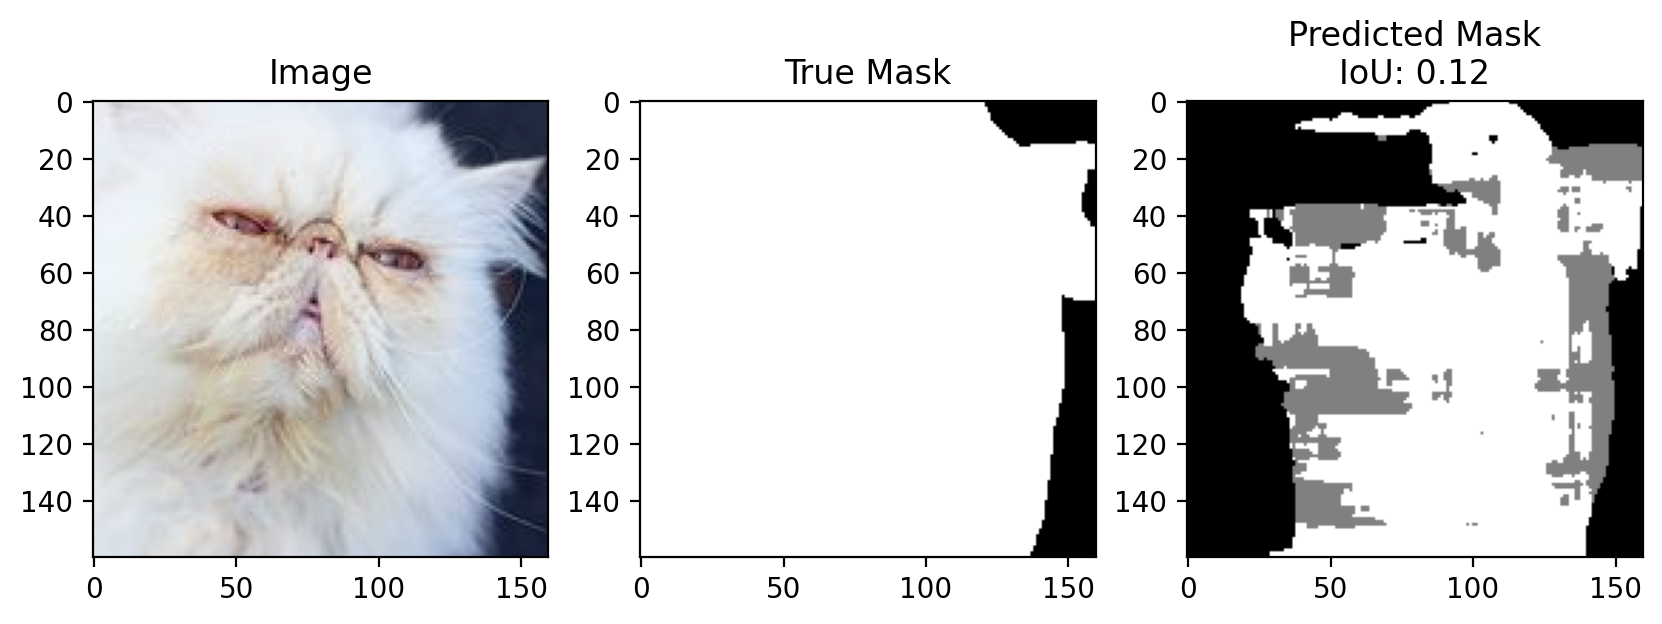

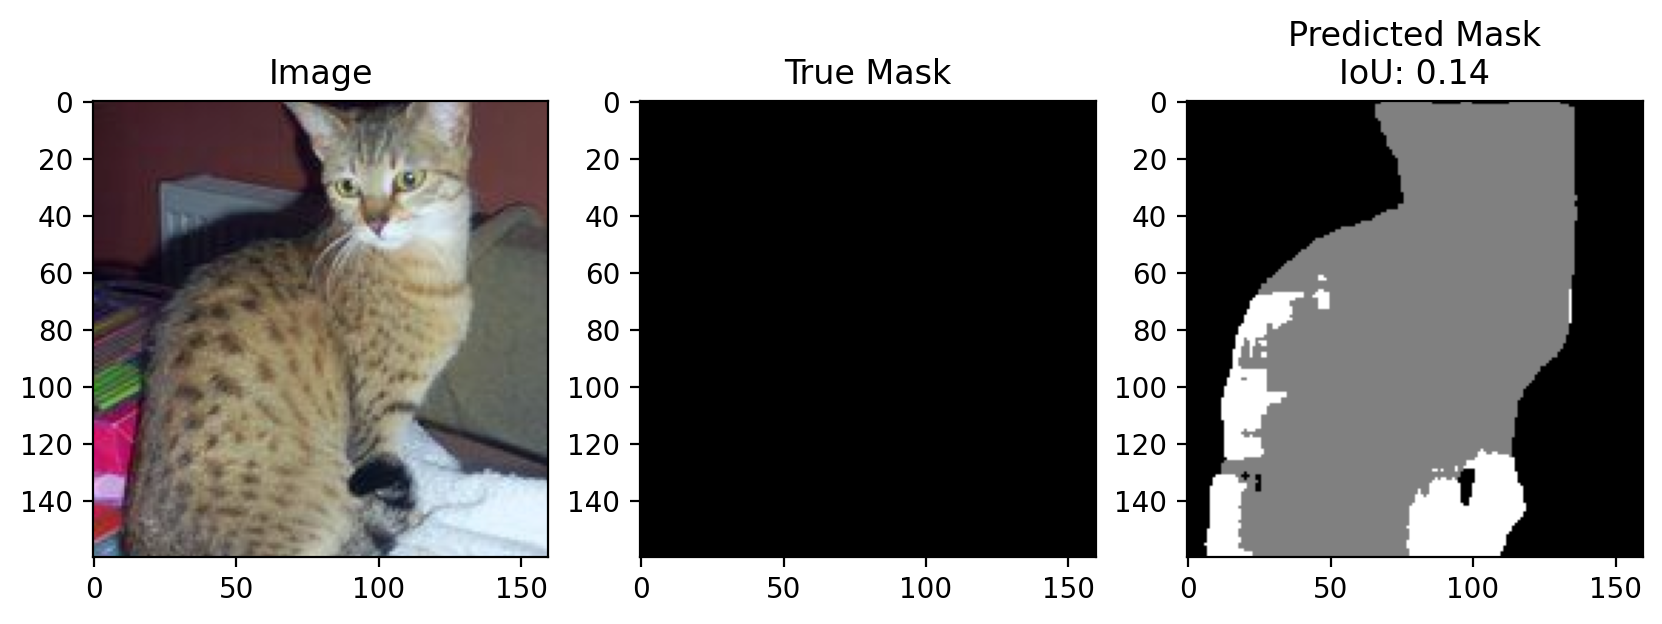

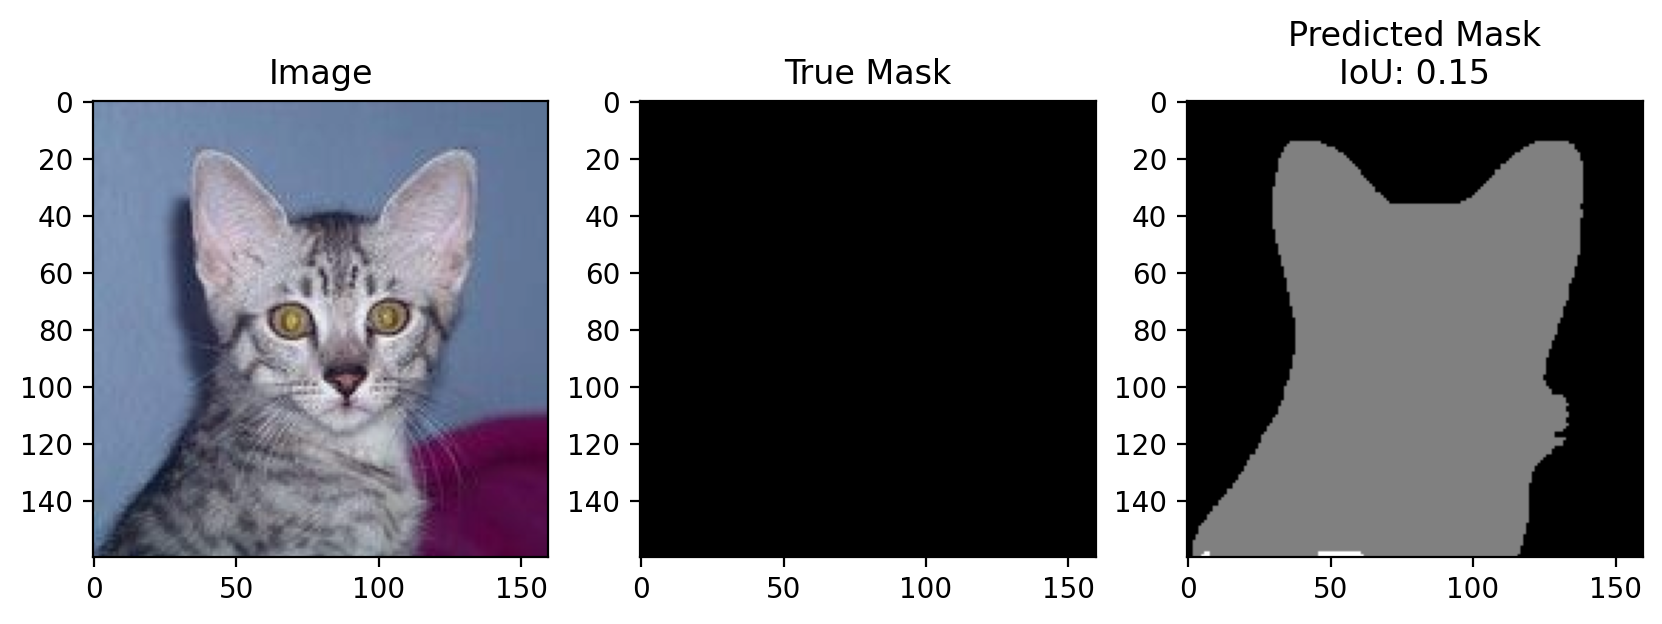

Displaying images with worst disagreement:


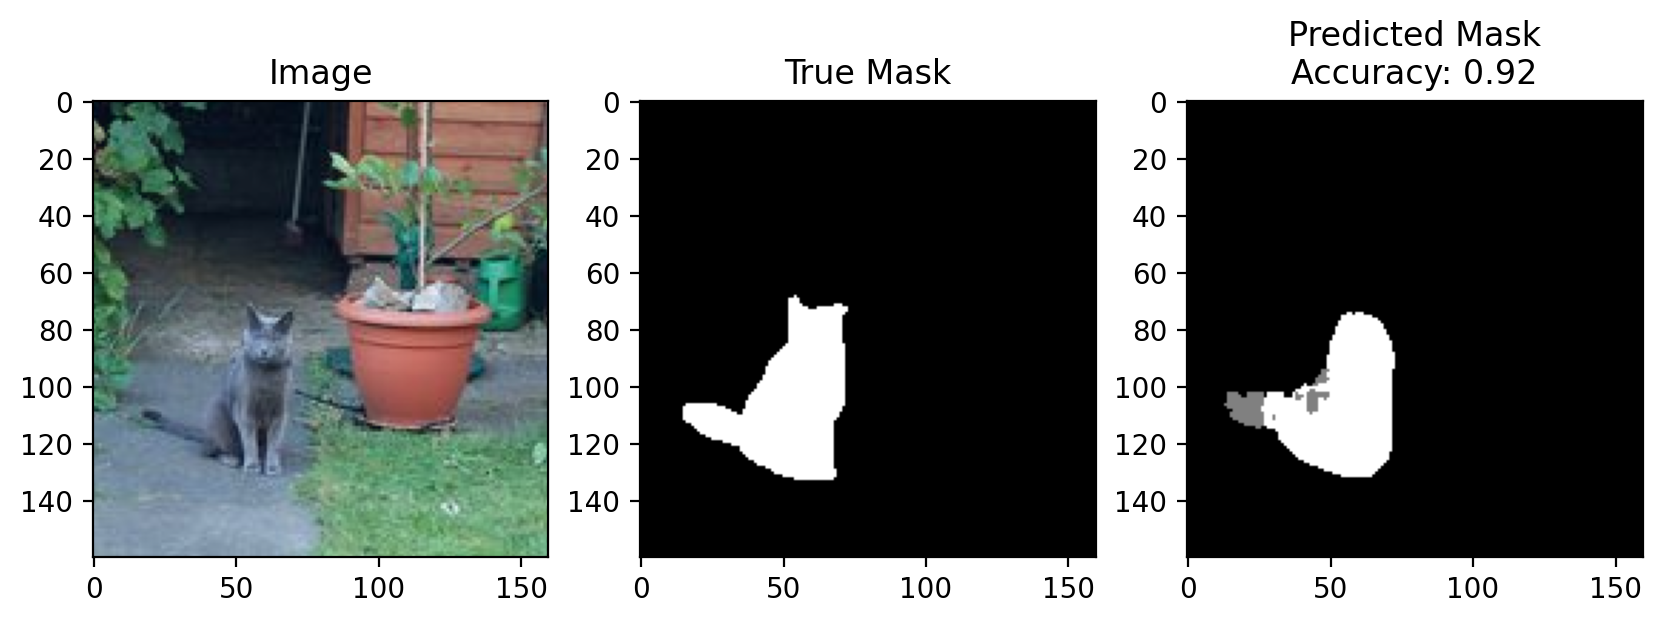

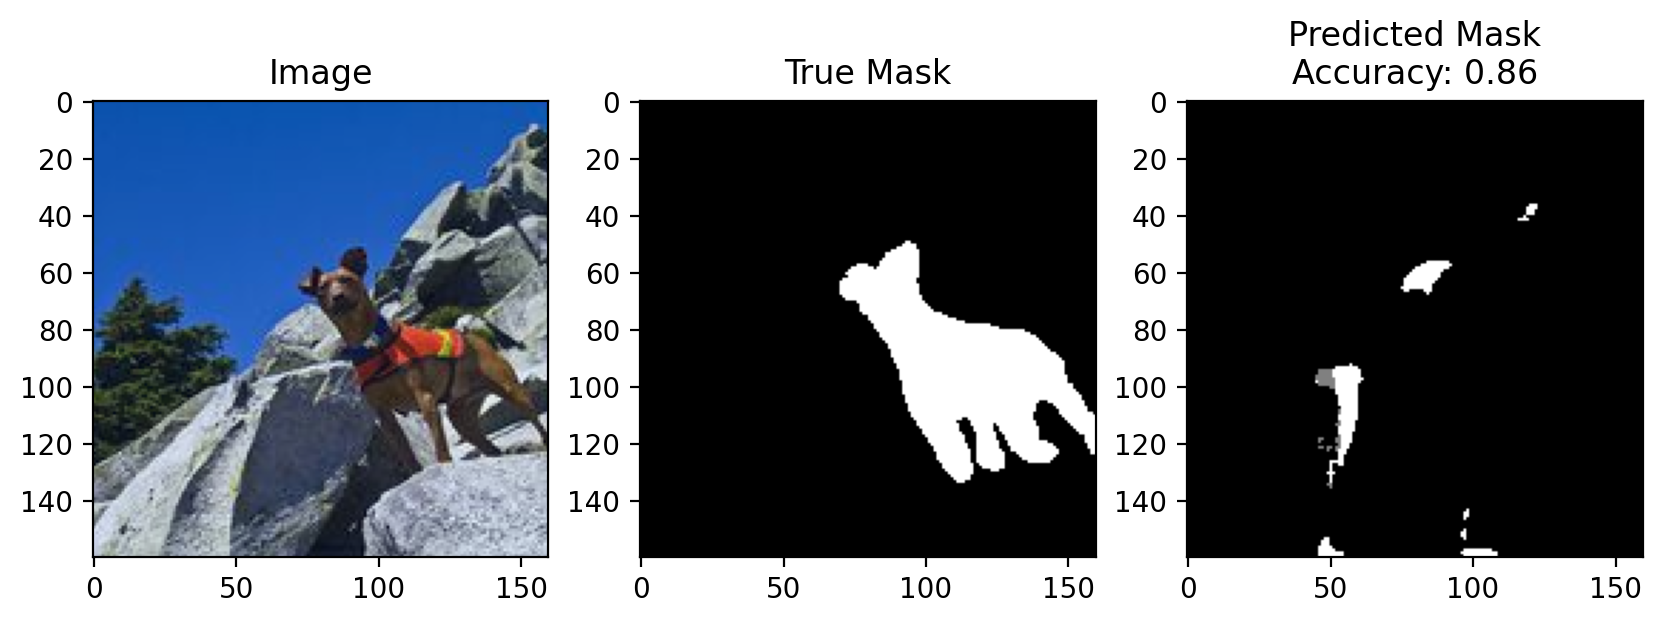

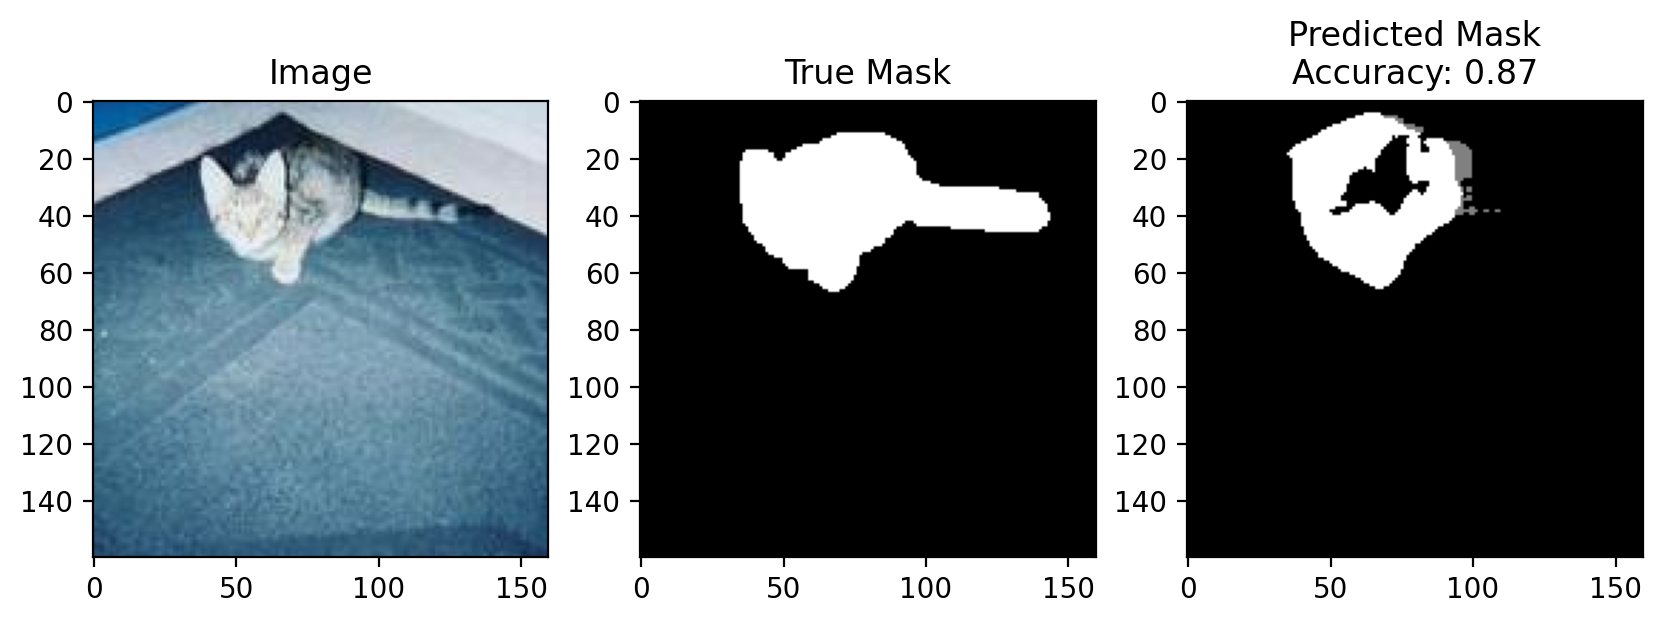

In [26]:
import matplotlib.pyplot as plt
import numpy as np

def show_badly_segmented_images(worst_iou, worst_disagreement, num_images=5):
    def scale_image(image):
        image = image - image.min()  # Shift to make the minimum value 0
        image = image / image.max()  # Scale to make the maximum value 1
        return image

    print("Displaying images with worst IoU:")
    for i in range(min(num_images, len(worst_iou))):
        images, predictions, labels, iou, acc = worst_iou[i]
        plt.figure(figsize=(10, 3))
        plt.subplot(1, 3, 1)
        image = images.transpose(1, 2, 0)  # Assuming images are in [C, H, W] format
        image = scale_image(image)  # Scale the image data
        plt.imshow(image)
        plt.title('Image')
        plt.subplot(1, 3, 2)
        plt.imshow(labels.squeeze(), cmap='gray')  # Squeeze to remove the channel dimension
        plt.title('True Mask')
        plt.subplot(1, 3, 3)
        plt.imshow(predictions.squeeze(), cmap='gray')  # Squeeze to remove the channel dimension
        plt.title(f'Predicted Mask\nIoU: {iou:.2f}')
        plt.show()

    print("Displaying images with worst disagreement:")
    for i in range(min(num_images, len(worst_disagreement))):
        images, predictions, labels, iou, acc = worst_disagreement[i]
        plt.figure(figsize=(10, 3))
        plt.subplot(1, 3, 1)
        image = images.transpose(1, 2, 0)  # Assuming images are in [C, H, W] format
        image = scale_image(image)  # Scale the image data
        plt.imshow(image)
        plt.title('Image')
        plt.subplot(1, 3, 2)
        plt.imshow(labels.squeeze(), cmap='gray')  # Squeeze to remove the channel dimension
        plt.title('True Mask')
        plt.subplot(1, 3, 3)
        plt.imshow(predictions.squeeze(), cmap='gray')  # Squeeze to remove the channel dimension
        plt.title(f'Predicted Mask\nAccuracy: {acc:.2f}')
        plt.show()

worst_iou = torch.load('/content/pet-segmentation/worst_iou.pt')
worst_disagreement = torch.load('/content/pet-segmentation/worst_disagreement.pt')
show_badly_segmented_images(worst_iou, worst_disagreement, num_images=3)  # Display only 3 images


In [28]:
worst_disagreement = torch.load(zip_file_path+'worst_disagreement.pt', map_location=DEVICE)
dis_prediction = torch.from_numpy(np.array([i[1] for i in worst_disagreement]))
dis_image = torch.from_numpy(np.array([i[0] for i in worst_disagreement]))
dis_label = torch.from_numpy(np.array([i[2] for i in worst_disagreement]))

In [29]:
worst_iou = torch.load(zip_file_path+'worst_iou.pt', map_location=DEVICE)
iou_prediction = torch.from_numpy(np.array([i[1] for i in worst_iou]))
iou_image = torch.from_numpy(np.array([i[0] for i in worst_iou]))
iou_label = torch.from_numpy(np.array([i[2] for i in worst_iou]))

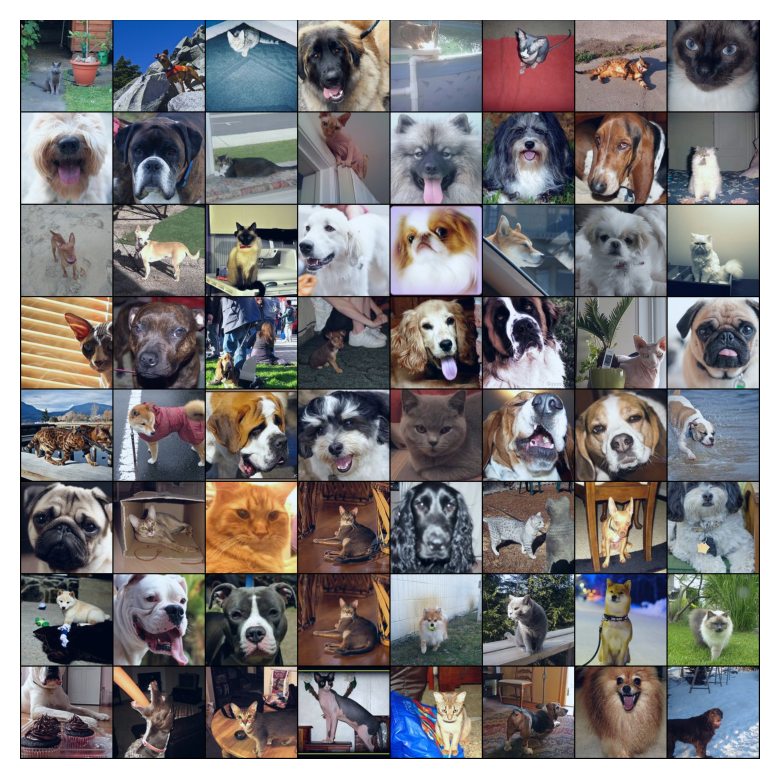

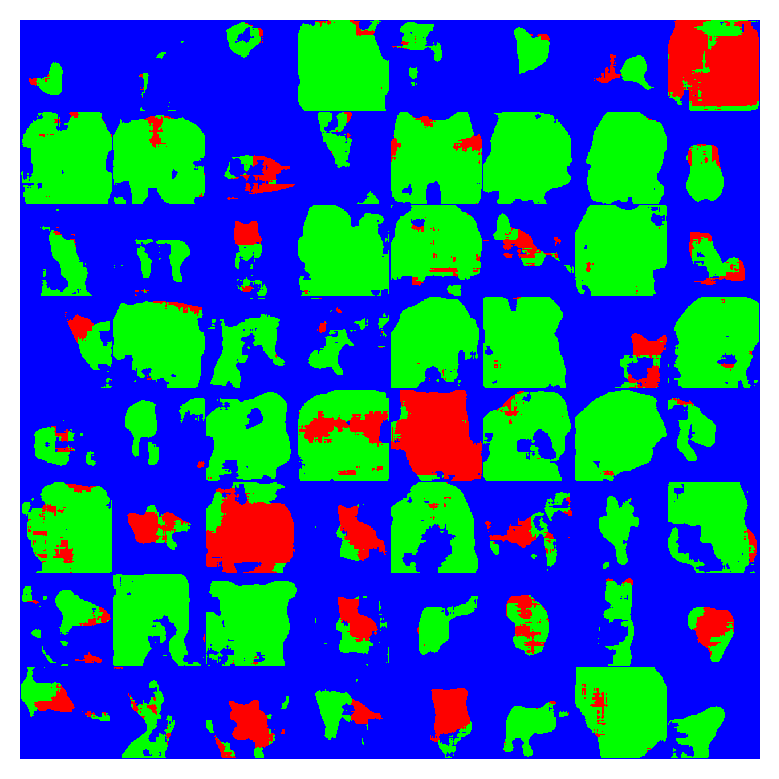

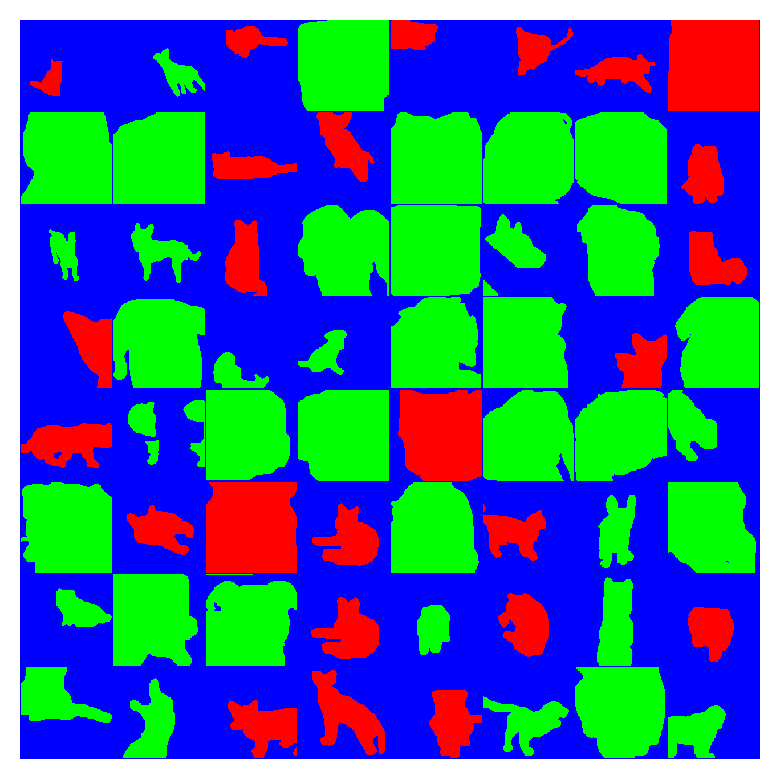

In [30]:
g = torchvision.utils.make_grid(dis_image, normalize = True)
plt.rcParams['figure.dpi'] = 200
plt.imshow(g.permute(1, 2, 0))
plt.axis("off")
plt.figure()

g = torchvision.utils.make_grid(dis_prediction.unsqueeze(1))
plt.imshow(g[0], interpolation = "nearest", cmap = "brg", vmin = 0, vmax = 2)
plt.axis("off")
plt.show()

g = torchvision.utils.make_grid(dis_label)
plt.imshow(g[0], interpolation = "nearest", cmap = "brg", vmin = 0, vmax = 2)
plt.axis("off")
plt.show()

In [31]:
iou_label.shape

torch.Size([64, 1, 160, 160])

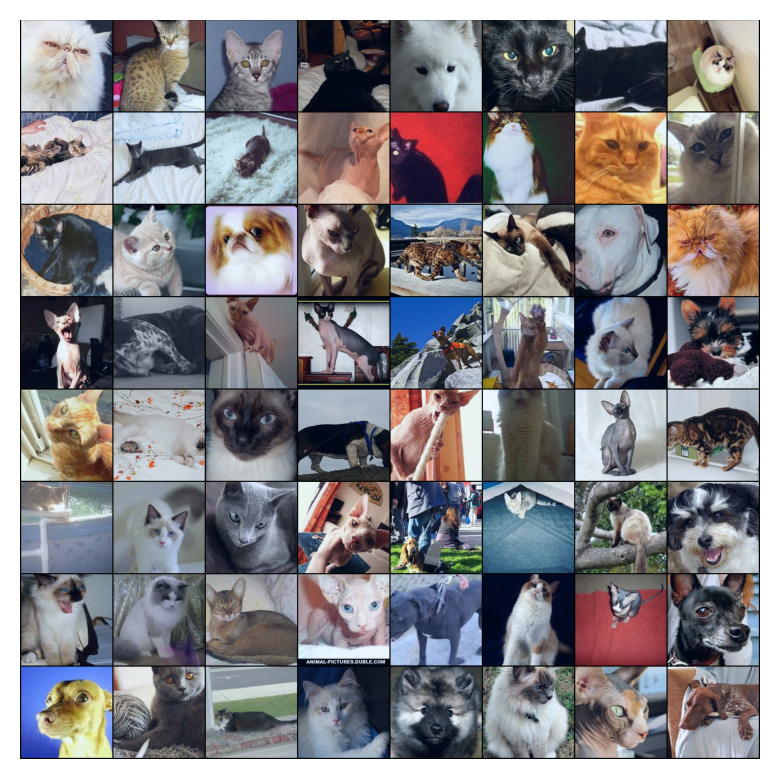

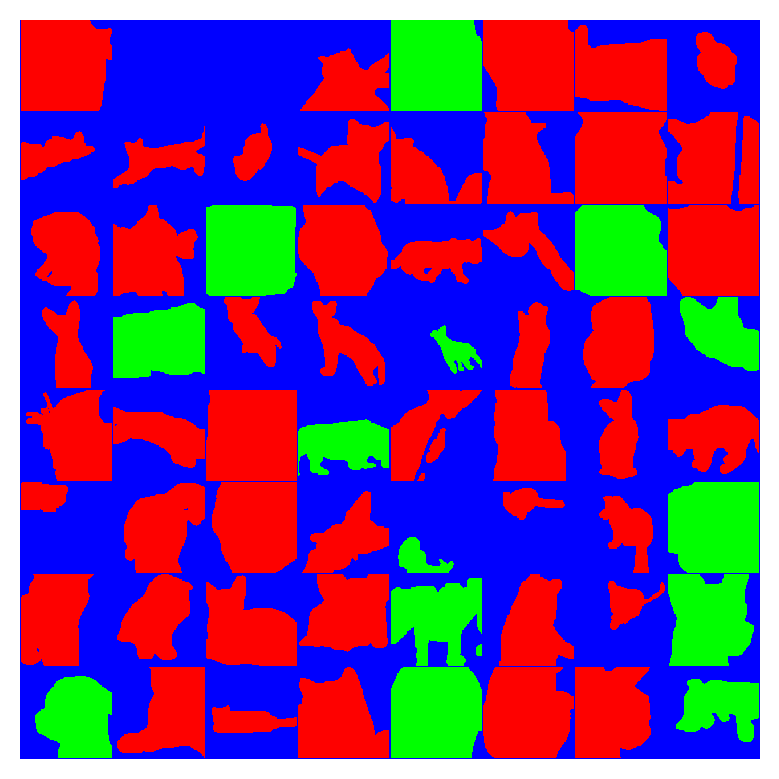

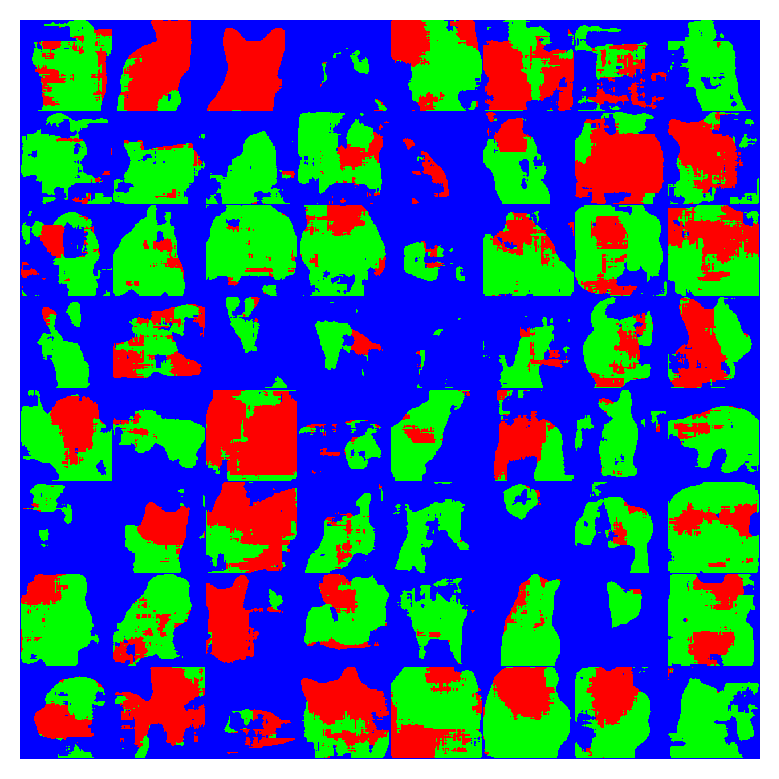

In [32]:
g = torchvision.utils.make_grid(iou_image, normalize = True)
plt.rcParams['figure.dpi'] = 200
plt.imshow(g.permute(1, 2, 0))
plt.axis("off")
plt.figure()

g = torchvision.utils.make_grid(iou_label)
plt.imshow(g[0], interpolation = "nearest", cmap = "brg", vmin = 0, vmax = 2)
plt.axis("off")
plt.show()

g = torchvision.utils.make_grid(iou_prediction.unsqueeze(1))
plt.imshow(g[0], interpolation = "nearest", cmap = "brg", vmin = 0, vmax = 2)
plt.axis("off")
plt.show()